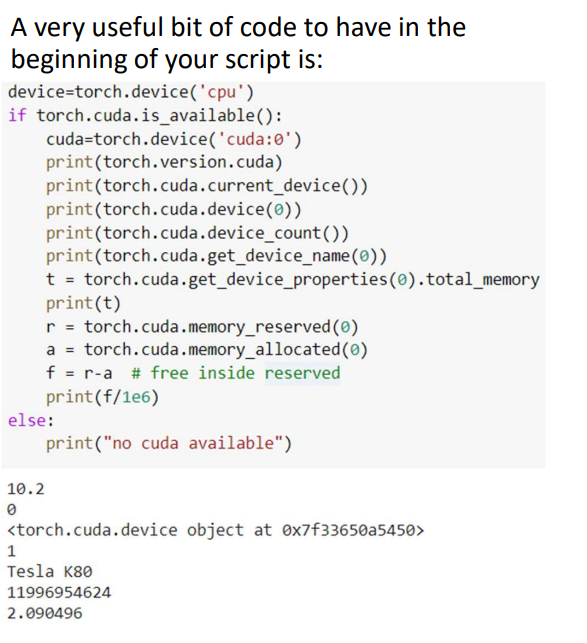

In [ ]:
import torch
from torch import nn
import sklearn.model_selection
import numpy as np

# For Binary classification
class LogisticRegressionPT(nn.Module):
  def __init__(self, input_features):
    super(LogisticRegressionPT, self).__init__()
    self.neuron = nn.Linear(input_features, 1, bias=True)

  def forward(self, x):
    x = self.neuron(x)
    x = torch.sigmoid(x)
    return torch.squeeze(x)

# For 10-ary classification
class StateOfTheArtNet(nn.Module):
  def __init__(self, input_features, input_nodes, middle_nodes, output_nodes):
    super(StateOfTheArtNet, self).__init__()
    self.inputLayer = nn.Linear(input_features, input_nodes, bias=True)
    self.hiddenLayer = nn.Linear(input_nodes, middle_nodes, bias=True)
    self.outputLayer = nn.Linear(middle_nodes, output_nodes, bias=True)
    #self.outActivation = nn.Softmax(dim=1)
    self.outActivation = nn.Sigmoid()


  def forward(self, x):
    x = self.inputLayer(x)
    x = torch.sigmoid(x)
    x = self.hiddenLayer(x)
    x = torch.sigmoid(x)
    x = self.outputLayer(x)
    x = self.outActivation(x)
    return torch.squeeze(x)

def trainModel(model, dataloader, nEpoch, optimizer, loss_fn, device_name):
  device = torch.device('cpu')
  if (device_name != 'cpu'):
    if torch.cuda.is_available():
      cuda = torch.device(device_name)
      print(torch.version.cuda)
      print(torch.cuda.device_count())
      print(torch.cuda.current_device())
      print(torch.cuda.device(0))
      print(torch.cuda.get_device_name(0))
      print(torch.cuda.get_device_properties(0).total_memory)
      r = torch.cuda.memory_reserved(0)
      a = torch.cuda.memory_allocated(0)
      f = r - a
      print(f/1e6)
    else:
      print("No cuda available")

  model.to(device)
  model.train()
  for iEpoch in range(nEpoch):
    estimatedLabels = np.empty((0,))
    trueLabels = np.empty((0,))
    for xbatch,ybatch in dataloader:
      xbatch.to(device)
      ybatch.to(device)
      y_pred = model(xbatch)
      loss = loss_fn(y_pred, ybatch)
      model.zero_grad()
      loss.backward()
      optimizer.step()

      if y_pred.dim()==1: # Used for binary classification
        yhat = y_pred>.5
      else: # Used for 10-class classification
        yhat = y_pred.argmax(1)
        ybatch = ybatch.argmax(1)

      estimatedLabels = np.append(estimatedLabels, yhat)
      trueLabels = np.append(trueLabels, ybatch)
    accuracy = np.mean(estimatedLabels == trueLabels)
    if (iEpoch%10) == 0:
      print('ipoch: {} - accuracy: {}'.format(iEpoch, accuracy))

def testModel(model, dataloader):
  estimatedLabels=np.empty((0,))
  trueLabels=np.empty((0,))
  model.eval()
  for xbatch,ybatch in dataloader:
      y_pred=model(xbatch)

      if y_pred.dim()==1: # Used for binary classification
        yhat = y_pred>.5
      else: # Used for 10-class classification
        yhat = y_pred.argmax(1)
        ybatch = ybatch.argmax(1)

      estimatedLabels=np.append(estimatedLabels,yhat)
      trueLabels=np.append(trueLabels,ybatch)

  testAcc=np.mean(estimatedLabels==trueLabels)
  print(f'testAcc: {testAcc}')

Load Binary MNIST dataset

In [ ]:
from mlxtend.data import mnist_data
X, y = mnist_data()
keep=(y==0) | (y==1)
X=X[keep,:]
y=y[keep]

Xtrain,Xtest,ytrain,ytest=sklearn.model_selection.train_test_split(X,y,test_size=0.3,shuffle=True)
trainDataset = torch.utils.data.TensorDataset(torch.tensor(Xtrain).float(), torch.tensor(ytrain).float())
testDataset = torch.utils.data.TensorDataset(torch.tensor(Xtest).float(), torch.tensor(ytest).float())

Define superparameters and train

In [ ]:
nEpoch = 100
learningRate = 0.001
batchSize = 64
trainDataLoader = torch.utils.data.DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testDataset, batch_size=batchSize, shuffle=True)
#
lrModel = LogisticRegressionPT(Xtrain.shape[1])
lrModel.neuron.weight.data = torch.zeros(1,784)

optimizer = torch.optim.SGD(lrModel.parameters(), lr=learningRate)
loss_fn = nn.functional.cross_entropy
#loss_fn = nn.BCELoss()
trainModel(lrModel, trainDataLoader, nEpoch, optimizer, loss_fn, 'cpu')

ipoch: 0 - accuracy: 0.9271428571428572
ipoch: 10 - accuracy: 0.9728571428571429
ipoch: 20 - accuracy: 0.9728571428571429
ipoch: 30 - accuracy: 0.9728571428571429
ipoch: 40 - accuracy: 0.9728571428571429
ipoch: 50 - accuracy: 0.9728571428571429
ipoch: 60 - accuracy: 0.9728571428571429
ipoch: 70 - accuracy: 0.9728571428571429
ipoch: 80 - accuracy: 0.9728571428571429
ipoch: 90 - accuracy: 0.9728571428571429


Load Full MNIST dataset

In [ ]:
from mlxtend.data import mnist_data
X, y = mnist_data()

Xtrain,Xtest,ytrain,ytest=sklearn.model_selection.train_test_split(X,y,test_size=0.3,shuffle=True)
ytrain = nn.functional.one_hot(torch.tensor(ytrain), num_classes=10)
ytest = nn.functional.one_hot(torch.tensor(ytest), num_classes=10)
ytrain = torch.tensor(ytrain)
ytest = torch.tensor(ytest)

trainDataset = torch.utils.data.TensorDataset(torch.tensor(Xtrain).float(), ytrain.float())
testDataset = torch.utils.data.TensorDataset(torch.tensor(Xtest).float(), ytest.float())
#
nEpoch = 200
learningRate = 0.002
batchSize = 64
trainDataLoader = torch.utils.data.DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testDataset, batch_size=batchSize, shuffle=True)
#
sotaModel = StateOfTheArtNet(Xtrain.shape[1], 128, 128,10)

#optimizer = torch.optim.SGD(sotaModel.parameters(), lr=learningRate)
optimizer = torch.optim.Adam(sotaModel.parameters(), lr=learningRate)
loss_fn = nn.functional.cross_entropy
trainModel(sotaModel, trainDataLoader, nEpoch, optimizer, loss_fn, 'cpu')


<ipython-input-4-5b0d9171b41c>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ytrain = torch.tensor(ytrain)
<ipython-input-4-5b0d9171b41c>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ytest = torch.tensor(ytest)


ipoch: 0 - accuracy: 0.42314285714285715
ipoch: 10 - accuracy: 0.8765714285714286
ipoch: 20 - accuracy: 0.8768571428571429
ipoch: 30 - accuracy: 0.896
ipoch: 40 - accuracy: 0.902
ipoch: 50 - accuracy: 0.9022857142857142
ipoch: 60 - accuracy: 0.896
ipoch: 70 - accuracy: 0.9051428571428571
ipoch: 80 - accuracy: 0.9257142857142857
ipoch: 90 - accuracy: 0.9157142857142857
ipoch: 100 - accuracy: 0.922
ipoch: 110 - accuracy: 0.928
ipoch: 120 - accuracy: 0.9297142857142857
ipoch: 130 - accuracy: 0.9274285714285714
ipoch: 140 - accuracy: 0.9225714285714286
ipoch: 150 - accuracy: 0.9302857142857143
ipoch: 160 - accuracy: 0.9257142857142857
ipoch: 170 - accuracy: 0.9342857142857143
ipoch: 180 - accuracy: 0.9437142857142857
ipoch: 190 - accuracy: 0.9311428571428572


In [ ]:
testModel(sotaModel, testDataLoader)

testAcc: 0.8853333333333333


  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=9f2d68752ec4ad5ffd91ff757816db515303bfb628a6829ff851b2dc7038d067
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz
StateOfTheArtNet(
  (inputLayer): Linear(in_features=784, out_features=128, bias=True)
  (hiddenLayer): Linear(in_features=128, out_features=128, bias=True)
  (outputLayer): Linear(in_features=128, out_features=10, bias=True)
  (outActivation): Sigmoid()
)


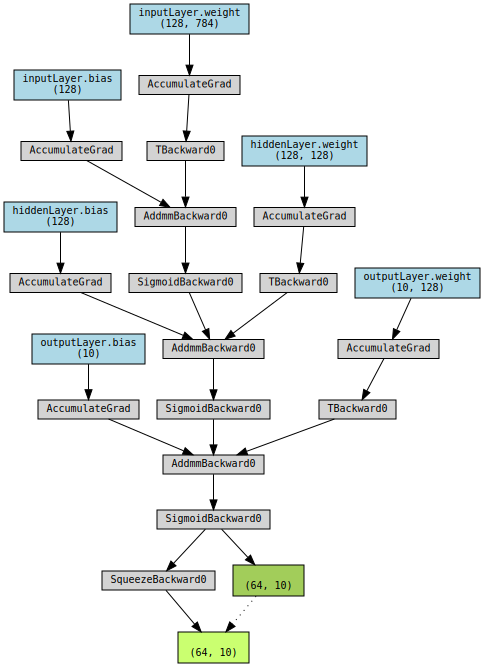

In [ ]:
#Model visualization
!pip install torchviz
from torchviz import make_dot, make_dot_from_trace

print(sotaModel)
X, y_true = next(iter(trainDataLoader))
make_dot(sotaModel(X), params=dict(sotaModel.named_parameters()))
